In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import sys
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss
from utils import Metrics, find_threshold, DataSet, Logger
from utils import LegendreFitter, expand_dims_as, Heaviside #,LegendreIntegral
from torch.autograd import gradcheck, Function
torch.set_printoptions(precision=4)
torch.manual_seed(72)

In [2]:
class LegendreIntegral(Function):
    @staticmethod
    def forward(ctx, input, fitter, s_edges=None,sbins=None):
        if s_edges is None:
            s_edges = torch.linspace(input.min().item(),input.max().item(),sbins+1)    #.view(-1,1,1)
        s = (s_edges[1:] + s_edges[:-1])*0.5
        s = expand_dims_as(s,input)
        ds = s_edges[1:] - s_edges[:-1]
        ds = expand_dims_as(ds,input)

        F = Heaviside(s-input).sum(axis=-1).float()/input.shape[-1]
        integral = ((F-fitter(F))**fitter.power*ds.view(-1,1)).sum(axis=0).sum()

        F_s_i =  expand_dims_as(input.view(-1),input)
        F_s_i =  Heaviside(F_s_i-input).sum(axis=-1).float()/input.shape[-1]
        residual = F_s_i - fitter(F_s_i)
        ctx.fitter = fitter
        ctx.residual = residual
        ctx.shape = input.shape

        return integral.double() # shape(mbins,)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = None
        shape = ctx.shape
        power = ctx.fitter.power
        dm = ctx.fitter.dm
        m = ctx.fitter.m
        if ctx.needs_input_grad[0]:
            rez_delta = ctx.residual.T.reshape(-1,shape[1])[(shape[0]+1)*np.arange(shape[0])].view(-1)
            grad_input = grad_output  \
             * (-power)*(rez_delta-ctx.residual.sum(axis=-1)*0.5*dm[0])/np.prod(shape)
            grad_input = grad_input.view(shape).double()

        return grad_input, None, None, None

In [3]:
mbins = 100
mcontent = 10
li = LegendreIntegral.apply
fitter = LegendreFitter(mbins=mbins,power=2)
inputTensor = torch.DoubleTensor(np.random.rand(mbins,mcontent)).sort(axis=1)[0]
inputTensor.requires_grad_(True)
None

In [4]:
inputTensor.dim()
shape = inputTensor.shape
rez = (expand_dims_as(inputTensor.view(-1),inputTensor)>inputTensor).float().sum(axis=-1)/mcontent
rez.T.reshape(-1,shape[1])[(shape[0]+1)*np.arange(shape[0])].shape

torch.Size([100, 10])

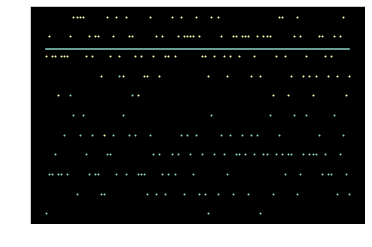

In [5]:
plt.scatter(fitter.m,rez[0],s=1)
plt.scatter(fitter.m,rez[8],s=1)
plt.plot(fitter.m,fitter(rez)[8])

In [17]:
sbins = 20000
ds = torch.linspace(0,1,sbins).double()
integral = li(inputTensor,fitter,
              ds
             )
integral

tensor(1.6512, dtype=torch.float64, grad_fn=<LegendreIntegralBackward>)

In [19]:
gradcheck(li,(inputTensor,fitter,
              ds
             ),eps=0.001,atol=0.01,)

RuntimeError: Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[ 0.1148],
        [ 0.0793],
        [ 0.0863],
        [ 0.0843],
        [ 0.0000],
        [ 0.0753],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.1048],
        [ 0.0843],
        [ 0.0000],
        [ 0.0043],
        [-0.0353],
        [ 0.0000],
        [ 0.0000],
        [ 0.0203],
        [ 0.0548],
        [ 0.0643],
        [ 0.0000],
        [ 0.0000],
        [-0.0703],
        [-0.0198],
        [ 0.0403],
        [ 0.0028],
        [ 0.0000],
        [-0.0173],
        [-0.0653],
        [-0.1118],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0082],
        [ 0.0000],
        [ 0.0093],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0822],
        [ 0.0000],
        [ 0.0207],
        [ 0.0000],
        [ 0.0000],
        [-0.0313],
        [ 0.0000],
        [ 0.0393],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0488],
        [ 0.0000],
        [-0.0683],
        [-0.0342],
        [-0.0543],
        [ 0.0000],
        [-0.0093],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.1111],
        [ 0.1448],
        [ 0.0000],
        [ 0.0728],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0188],
        [ 0.0000],
        [ 0.0000],
        [-0.0718],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.1058],
        [-0.1098],
        [-0.0388],
        [ 0.0000],
        [ 0.0000],
        [-0.0188],
        [ 0.0000],
        [ 0.0000],
        [-0.0873],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.1438],
        [ 0.0000],
        [ 0.0658],
        [ 0.0000],
        [ 0.0143],
        [ 0.0000],
        [-0.0523],
        [-0.0718],
        [-0.0978],
        [ 0.0103],
        [-0.0183],
        [-0.0442],
        [ 0.0000],
        [-0.0593],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0792],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0518],
        [-0.0938],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0832],
        [ 0.0253],
        [-0.0128],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0453],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0043],
        [ 0.0000],
        [ 0.0243],
        [ 0.0000],
        [-0.0008],
        [ 0.0000],
        [ 0.0563],
        [ 0.0000],
        [ 0.0097],
        [ 0.0000],
        [ 0.0000],
        [ 0.0293],
        [ 0.0000],
        [-0.0532],
        [-0.0968],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0128],
        [ 0.0503],
        [ 0.0000],
        [ 0.0467],
        [ 0.0143],
        [ 0.0308],
        [ 0.0000],
        [ 0.0033],
        [ 0.0000],
        [ 0.0000],
        [ 0.0303],
        [ 0.0000],
        [ 0.0178],
        [-0.0223],
        [ 0.0000],
        [ 0.0000],
        [ 0.0527],
        [ 0.0000],
        [-0.0303],
        [-0.0128],
        [ 0.1053],
        [ 0.0000],
        [ 0.0000],
        [ 0.1263],
        [ 0.0913],
        [ 0.0000],
        [ 0.0432],
        [ 0.0000],
        [ 0.0303],
        [-0.0178],
        [ 0.0000],
        [ 0.0823],
        [ 0.0000],
        [ 0.0593],
        [ 0.0000],
        [ 0.0000],
        [ 0.1408],
        [ 0.0000],
        [ 0.0000],
        [ 0.0218],
        [-0.0108],
        [ 0.0053],
        [ 0.0000],
        [ 0.0000],
        [-0.0597],
        [-0.0988],
        [-0.1333],
        [-0.1128],
        [-0.1438],
        [ 0.0000],
        [-0.0073],
        [-0.0158],
        [ 0.0000],
        [ 0.0028],
        [-0.0423],
        [ 0.0000],
        [-0.0138],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0273],
        [ 0.0000],
        [-0.0108],
        [-0.0288],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0448],
        [-0.0753],
        [ 0.0000],
        [ 0.0000],
        [-0.0348],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.1943],
        [-0.1608],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0627],
        [ 0.0000],
        [ 0.0763],
        [ 0.0000],
        [ 0.0503],
        [ 0.0192],
        [ 0.0063],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0248],
        [ 0.0000],
        [-0.0748],
        [-0.0763],
        [ 0.0000],
        [ 0.0000],
        [-0.0238],
        [-0.0508],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.1558],
        [ 0.0000],
        [ 0.0000],
        [-0.0133],
        [ 0.0000],
        [ 0.0000],
        [-0.0913],
        [-0.1203],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0883],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0558],
        [-0.1023],
        [ 0.0883],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0048],
        [ 0.0000],
        [ 0.0633],
        [ 0.0000],
        [ 0.0000],
        [ 0.1426],
        [ 0.1183],
        [ 0.1183],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0033],
        [ 0.0000],
        [ 0.0000],
        [ 0.0073],
        [-0.0303],
        [ 0.0000],
        [-0.0073],
        [ 0.0000],
        [ 0.0000],
        [ 0.0028],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.1098],
        [ 0.0692],
        [ 0.0000],
        [ 0.0000],
        [ 0.0973],
        [ 0.0000],
        [ 0.0148],
        [ 0.0842],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0323],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0033],
        [ 0.0000],
        [-0.0598],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0498],
        [ 0.0000],
        [-0.0912],
        [-0.0158],
        [-0.0508],
        [-0.0537],
        [ 0.0000],
        [ 0.0000],
        [-0.0488],
        [ 0.0000],
        [-0.0703],
        [ 0.0000],
        [ 0.0000],
        [ 0.0908],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0393],
        [-0.0127],
        [ 0.0000],
        [ 0.0000],
        [-0.0463],
        [ 0.0000],
        [ 0.0000],
        [-0.0343],
        [ 0.0398],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0143],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0398],
        [-0.0082],
        [ 0.0000],
        [-0.0488],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.1153],
        [ 0.0698],
        [ 0.0000],
        [ 0.0103],
        [-0.0077],
        [ 0.0418],
        [ 0.0218],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0533],
        [ 0.0000],
        [ 0.0000],
        [ 0.0853],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0163],
        [-0.0023],
        [ 0.0418],
        [ 0.0000],
        [-0.0133],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0038],
        [ 0.0000],
        [ 0.0000],
        [-0.0173],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0633],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0198],
        [-0.0082],
        [-0.0573],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0473],
        [-0.0443],
        [-0.0278],
        [ 0.0000],
        [ 0.0000],
        [ 0.0748],
        [ 0.0793],
        [ 0.0318],
        [ 0.0368],
        [ 0.0000],
        [ 0.0000],
        [-0.0388],
        [ 0.0000],
        [ 0.0092],
        [ 0.0000],
        [-0.0067],
        [ 0.0000],
        [-0.0487],
        [ 0.0000],
        [ 0.0000],
        [-0.0568],
        [ 0.0000],
        [ 0.0000],
        [-0.0053],
        [ 0.0000],
        [ 0.0000],
        [-0.0238],
        [ 0.0000],
        [-0.0582],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0398],
        [ 0.0000],
        [ 0.0000],
        [ 0.0227],
        [ 0.0713],
        [ 0.0000],
        [ 0.0413],
        [ 0.0000],
        [ 0.0000],
        [-0.0178],
        [-0.0163],
        [-0.0368],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0813],
        [-0.1133],
        [-0.0942],
        [ 0.0000],
        [-0.1218],
        [ 0.0000],
        [ 0.0000],
        [ 0.1283],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0368],
        [-0.0053],
        [ 0.0000],
        [-0.0538],
        [ 0.0000],
        [ 0.0000],
        [ 0.0023],
        [ 0.0000],
        [ 0.0000],
        [-0.0307],
        [-0.0513],
        [ 0.0000],
        [ 0.0328],
        [ 0.0000],
        [ 0.0068],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0403],
        [ 0.0248],
        [ 0.0000],
        [ 0.0233],
        [ 0.1768],
        [ 0.0000],
        [ 0.0000],
        [ 0.0673],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0478],
        [ 0.0000],
        [ 0.0028],
        [ 0.0000],
        [-0.0518],
        [-0.0847],
        [-0.1088],
        [-0.1158],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.1713],
        [-0.0018],
        [ 0.0000],
        [ 0.0000],
        [ 0.0223],
        [ 0.0000],
        [-0.0063],
        [ 0.0373],
        [ 0.0018],
        [ 0.0378],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0978],
        [ 0.0000],
        [ 0.0003],
        [ 0.0000],
        [-0.0513],
        [-0.0963],
        [ 0.0000],
        [-0.0093],
        [-0.0092],
        [-0.0503],
        [-0.0713],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.1403],
        [-0.0928],
        [-0.0533],
        [-0.0123],
        [ 0.0268],
        [ 0.0043],
        [ 0.0093],
        [-0.0053],
        [-0.0547],
        [ 0.0000],
        [ 0.0368],
        [ 0.0508],
        [ 0.0000],
        [ 0.0000],
        [-0.0123],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0653],
        [ 0.0843],
        [ 0.0000],
        [ 0.0000],
        [ 0.0128],
        [-0.0283],
        [-0.0252],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0323],
        [ 0.0038],
        [ 0.0000],
        [ 0.0753],
        [ 0.0338],
        [ 0.0000],
        [ 0.0733],
        [ 0.0363],
        [-0.0078],
        [-0.0417],
        [ 0.0000],
        [ 0.0000],
        [-0.0288],
        [ 0.0000],
        [-0.0103],
        [ 0.0063],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0238],
        [ 0.0000],
        [ 0.0000],
        [-0.0498],
        [-0.0113],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.1078],
        [ 0.0000],
        [-0.0063],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0372],
        [ 0.0000],
        [-0.0123],
        [ 0.0000],
        [ 0.0000],
        [-0.0618],
        [ 0.0000],
        [-0.0138],
        [ 0.0063],
        [-0.0293],
        [ 0.0000],
        [-0.0518],
        [ 0.0000],
        [-0.0343],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0528],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0533],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0433],
        [ 0.0013],
        [ 0.0000],
        [-0.0483],
        [ 0.0000],
        [-0.0822],
        [ 0.0000],
        [ 0.0000],
        [ 0.0773],
        [ 0.0000],
        [ 0.0000],
        [ 0.0138],
        [ 0.0083],
        [-0.0173],
        [ 0.0000],
        [-0.0343],
        [ 0.0000],
        [-0.0893],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0783],
        [-0.1233],
        [ 0.0000],
        [ 0.0000],
        [-0.0453],
        [ 0.0168],
        [ 0.2408],
        [ 0.2258],
        [ 0.0000],
        [ 0.1651],
        [ 0.0000],
        [ 0.1358],
        [ 0.0000],
        [ 0.0768],
        [ 0.0663],
        [ 0.0000],
        [ 0.0348],
        [ 0.0000],
        [ 0.0077],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.1153],
        [ 0.0000],
        [ 0.0000],
        [ 0.0097],
        [ 0.0000],
        [-0.0198],
        [ 0.0000],
        [ 0.0000],
        [-0.0018],
        [ 0.0000],
        [ 0.0000],
        [ 0.0123],
        [ 0.0000],
        [ 0.0000],
        [-0.0723],
        [-0.0952],
        [ 0.0000],
        [ 0.0000],
        [-0.0613],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.1758],
        [ 0.0000],
        [ 0.1043],
        [ 0.0000],
        [ 0.0963],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0178],
        [-0.0168],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0243],
        [-0.0023],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0403],
        [ 0.0000],
        [ 0.0000],
        [-0.0928],
        [ 0.0000],
        [ 0.0000],
        [-0.0248],
        [-0.0713],
        [ 0.0000],
        [-0.0278],
        [ 0.0000],
        [-0.0118],
        [ 0.0000],
        [ 0.0000],
        [-0.0653],
        [-0.0798],
        [-0.0228],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.1226],
        [ 0.0000],
        [ 0.0000],
        [ 0.0297],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0118],
        [ 0.0000],
        [ 0.0053],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0213],
        [ 0.0228],
        [ 0.0198],
        [-0.0102],
        [ 0.0000],
        [ 0.0123],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0108],
        [ 0.0078],
        [ 0.0000],
        [-0.0572],
        [-0.0863],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0313],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0573],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0857],
        [-0.0723],
        [ 0.0000],
        [ 0.0448],
        [ 0.0258],
        [ 0.0000],
        [ 0.0653],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0233],
        [-0.0068],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0213],
        [ 0.0088],
        [ 0.0000],
        [ 0.0000],
        [ 0.0122],
        [ 0.0000],
        [ 0.0000],
        [-0.0408],
        [-0.0763],
        [ 0.0000],
        [-0.1638],
        [ 0.0000],
        [ 0.0000],
        [ 0.0383],
        [ 0.0000],
        [-0.0278],
        [-0.0243],
        [ 0.0257],
        [ 0.0000],
        [ 0.0000],
        [ 0.0668],
        [ 0.0000],
        [ 0.0000],
        [ 0.0568],
        [ 0.0000],
        [ 0.0000],
        [ 0.0423],
        [ 0.0193],
        [-0.0138],
        [ 0.0523],
        [ 0.0000],
        [ 0.0000],
        [ 0.1163],
        [ 0.1071],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0048],
        [ 0.0000],
        [ 0.0458],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0233],
        [ 0.0000],
        [ 0.0000],
        [-0.0048],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0688],
        [ 0.0000],
        [-0.0408],
        [ 0.0000],
        [ 0.0000],
        [ 0.0563],
        [ 0.0568],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0553],
        [ 0.0123],
        [-0.0028],
        [-0.0082],
        [ 0.0000],
        [-0.0463],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0488],
        [ 0.0683],
        [ 0.0000],
        [ 0.0523],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0993],
        [ 0.0000],
        [ 0.0388],
        [ 0.0000],
        [ 0.0383],
        [ 0.0198],
        [ 0.0000],
        [ 0.0000],
        [-0.0562],
        [ 0.0000],
        [-0.1263],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.1183],
        [ 0.0000],
        [ 0.0000],
        [ 0.1068],
        [ 0.0733],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0148],
        [ 0.0000],
        [ 0.0063],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0032],
        [ 0.0000],
        [-0.0352],
        [-0.0778],
        [-0.0523],
        [ 0.0000],
        [-0.0653],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0178],
        [ 0.0233],
        [ 0.0000],
        [ 0.0258],
        [ 0.0000],
        [ 0.0000],
        [ 0.1208],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.1373],
        [ 0.0000],
        [ 0.0953],
        [ 0.0898],
        [ 0.0463],
        [ 0.0098],
        [ 0.0000],
        [ 0.0723],
        [ 0.0000]], dtype=torch.float64)
analytical:tensor([[ 5.5800e-04],
        [ 4.1600e-04],
        [ 4.4400e-04],
        [ 4.3600e-04],
        [ 4.7200e-04],
        [ 4.0000e-04],
        [ 3.0400e-04],
        [ 2.4800e-04],
        [ 6.8000e-05],
        [ 1.2000e-04],
        [ 3.0200e-04],
        [ 3.0800e-04],
        [ 4.2000e-04],
        [ 5.1800e-04],
        [ 4.3600e-04],
        [ 2.5000e-04],
        [ 1.1600e-04],
        [-4.2000e-05],
        [-8.0000e-05],
        [ 1.2200e-04],
        [ 1.8000e-04],
        [ 3.1800e-04],
        [ 3.5600e-04],
        [ 1.8000e-04],
        [-6.0000e-06],
        [-1.8200e-04],
        [ 2.0000e-05],
        [ 2.6000e-04],
        [ 1.1000e-04],
        [-8.2000e-05],
        [ 3.0000e-05],
        [-1.6200e-04],
        [-3.4800e-04],
        [ 5.0000e-05],
        [ 6.6000e-05],
        [-1.1600e-04],
        [-2.5400e-04],
        [ 6.6000e-05],
        [ 1.1600e-04],
        [ 2.0000e-06],
        [ 1.4400e-04],
        [ 1.6800e-04],
        [ 2.8200e-04],
        [ 1.3200e-04],
        [-6.0000e-05],
        [ 1.3600e-04],
        [ 5.0600e-04],
        [ 3.2800e-04],
        [ 1.7800e-04],
        [ 1.7000e-04],
        [ 4.2800e-04],
        [ 2.9000e-04],
        [ 1.8200e-04],
        [ 4.0000e-05],
        [-1.2200e-04],
        [-2.6000e-05],
        [ 4.2000e-04],
        [ 2.5600e-04],
        [ 2.3800e-04],
        [ 1.1800e-04],
        [ 4.0000e-06],
        [-9.6000e-05],
        [-2.7000e-04],
        [-1.7400e-04],
        [-3.8000e-05],
        [-1.1800e-04],
        [-9.6000e-05],
        [ 6.2000e-05],
        [ 1.9600e-04],
        [ 8.6000e-05],
        [ 1.8000e-05],
        [-1.2600e-04],
        [ 2.8000e-04],
        [ 5.4400e-04],
        [ 6.7800e-04],
        [ 5.0000e-04],
        [ 3.9000e-04],
        [ 2.3600e-04],
        [ 9.6000e-05],
        [ 4.4000e-05],
        [ 2.4000e-05],
        [-4.4000e-05],
        [-1.6800e-04],
        [-1.8800e-04],
        [-2.7200e-04],
        [-4.5400e-04],
        [-3.3600e-04],
        [-3.2400e-04],
        [-3.4000e-04],
        [-5.6000e-05],
        [ 5.8000e-05],
        [ 3.4000e-05],
        [ 2.4000e-05],
        [-1.4000e-04],
        [-3.0400e-04],
        [-2.5000e-04],
        [-4.4800e-04],
        [ 7.4000e-05],
        [-9.8000e-05],
        [-2.0400e-04],
        [ 1.2000e-04],
        [ 6.7400e-04],
        [ 4.8800e-04],
        [ 3.6200e-04],
        [ 2.1800e-04],
        [ 1.5600e-04],
        [-4.0000e-06],
        [-1.1000e-04],
        [-1.8800e-04],
        [-2.9200e-04],
        [ 1.4000e-04],
        [ 2.6000e-05],
        [-7.8000e-05],
        [-1.4400e-04],
        [-1.3800e-04],
        [-2.9400e-04],
        [-1.9400e-04],
        [-2.1400e-04],
        [-2.1800e-04],
        [-2.3800e-04],
        [ 2.2000e-05],
        [-2.8000e-05],
        [-2.2400e-04],
        [-1.0800e-04],
        [-2.7600e-04],
        [-2.4200e-04],
        [-5.8000e-05],
        [ 2.4000e-05],
        [-1.1200e-04],
        [-2.3400e-04],
        [ 2.0000e-04],
        [ 4.8000e-05],
        [-2.8000e-05],
        [ 9.8000e-05],
        [ 3.6000e-05],
        [ 2.8000e-04],
        [ 3.2400e-04],
        [ 1.4200e-04],
        [ 1.3000e-04],
        [ 8.2000e-05],
        [ 2.4000e-04],
        [ 1.9600e-04],
        [ 2.4400e-04],
        [ 9.6000e-05],
        [ 3.5200e-04],
        [ 3.2400e-04],
        [ 1.3400e-04],
        [ 1.3800e-04],
        [ 5.0000e-05],
        [-5.4000e-05],
        [ 2.1600e-04],
        [ 2.2000e-05],
        [-1.1400e-04],
        [-2.8800e-04],
        [ 4.0000e-06],
        [-1.3000e-04],
        [ 3.2200e-04],
        [ 2.0200e-04],
        [ 1.5000e-04],
        [ 2.4000e-05],
        [ 4.8000e-05],
        [ 3.0000e-04],
        [ 2.5600e-04],
        [ 2.8600e-04],
        [ 1.5600e-04],
        [ 2.2200e-04],
        [ 2.2000e-04],
        [ 1.1200e-04],
        [-1.8000e-05],
        [ 1.4600e-04],
        [ 2.2000e-04],
        [ 9.4000e-05],
        [ 1.7000e-04],
        [ 1.0000e-05],
        [ 1.4400e-04],
        [ 4.6400e-04],
        [ 3.1000e-04],
        [ 1.7600e-04],
        [-2.2000e-05],
        [ 4.8000e-05],
        [ 5.2000e-04],
        [ 3.6000e-04],
        [ 3.6800e-04],
        [ 6.0400e-04],
        [ 4.6400e-04],
        [ 3.6200e-04],
        [ 2.7200e-04],
        [ 2.8800e-04],
        [ 2.2000e-04],
        [ 2.8000e-05],
        [ 1.3800e-04],
        [ 4.2800e-04],
        [ 3.6000e-04],
        [ 3.3600e-04],
        [ 9.5600e-04],
        [ 8.3000e-04],
        [ 6.6200e-04],
        [ 5.4000e-04],
        [ 3.4200e-04],
        [ 1.8600e-04],
        [ 5.6000e-05],
        [ 1.2000e-04],
        [ 1.1000e-04],
        [-1.0000e-05],
        [-1.4000e-04],
        [-2.9600e-04],
        [-4.3400e-04],
        [-3.5200e-04],
        [-4.7600e-04],
        [-5.2600e-04],
        [ 7.0000e-05],
        [ 3.6000e-05],
        [-6.6000e-05],
        [ 1.1000e-04],
        [-7.0000e-05],
        [ 1.6800e-04],
        [ 4.4000e-05],
        [ 4.2000e-05],
        [ 1.9000e-04],
        [ 1.1400e-04],
        [ 8.4000e-05],
        [ 1.2000e-05],
        [-5.2000e-05],
        [-6.6000e-05],
        [ 3.2200e-04],
        [ 2.0800e-04],
        [ 1.6800e-04],
        [ 5.6000e-05],
        [-1.6000e-05],
        [ 1.7400e-04],
        [ 1.9600e-04],
        [ 3.5600e-04],
        [ 2.6800e-04],
        [ 2.2400e-04],
        [ 1.6400e-04],
        [ 1.8800e-04],
        [ 3.2000e-05],
        [-8.0000e-05],
        [-2.0200e-04],
        [-2.3600e-04],
        [ 6.4000e-05],
        [-4.0000e-05],
        [-2.1200e-04],
        [-2.6000e-04],
        [-4.2600e-04],
        [-5.2800e-04],
        [-6.7800e-04],
        [-5.4400e-04],
        [ 1.2000e-04],
        [ 1.9000e-04],
        [ 3.3200e-04],
        [ 1.4400e-04],
        [ 2.2000e-05],
        [-1.5200e-04],
        [-3.1800e-04],
        [ 4.0400e-04],
        [ 2.2200e-04],
        [ 3.0000e-04],
        [ 1.7600e-04],
        [ 1.2400e-04],
        [ 2.7800e-04],
        [ 2.0800e-04],
        [ 2.0400e-04],
        [ 1.0000e-04],
        [-8.8000e-05],
        [ 1.4900e-11],
        [-1.1200e-04],
        [-2.0000e-04],
        [-2.0600e-04],
        [-3.6000e-04],
        [ 1.5400e-04],
        [ 4.0000e-06],
        [-1.0400e-04],
        [-1.1200e-04],
        [-2.2400e-04],
        [-3.7000e-04],
        [-5.2400e-04],
        [-4.1000e-04],
        [ 2.8000e-05],
        [ 4.6000e-05],
        [ 8.8000e-05],
        [-1.0600e-04],
        [-2.6600e-04],
        [-3.8200e-04],
        [-4.9600e-04],
        [-5.8200e-04],
        [-3.7800e-04],
        [-2.5400e-04],
        [-4.4000e-05],
        [ 2.2000e-05],
        [ 8.0000e-05],
        [-3.6000e-05],
        [-1.2400e-04],
        [-3.1000e-04],
        [ 4.5200e-04],
        [ 3.4800e-04],
        [ 3.6800e-04],
        [ 2.5800e-04],
        [ 8.4000e-05],
        [ 8.0000e-05],
        [ 4.3800e-04],
        [ 3.5200e-04],
        [ 5.5200e-04],
        [ 7.0600e-04],
        [ 6.7000e-04],
        [ 5.7200e-04],
        [ 5.7200e-04],
        [ 3.8000e-04],
        [ 2.0800e-04],
        [ 1.0800e-04],
        [ 8.6000e-05],
        [-3.0000e-05],
        [ 2.4200e-04],
        [ 1.2800e-04],
        [-2.2000e-05],
        [-2.0400e-04],
        [ 7.0000e-05],
        [-8.8000e-05],
        [ 8.0000e-05],
        [ 1.1000e-04],
        [ 4.2000e-05],
        [ 2.4200e-04],
        [ 6.2400e-04],
        [ 5.3800e-04],
        [ 3.7600e-04],
        [ 2.8800e-04],
        [ 2.8200e-04],
        [ 4.8800e-04],
        [ 3.1600e-04],
        [ 1.5800e-04],
        [ 4.3600e-04],
        [ 4.1800e-04],
        [ 2.8800e-04],
        [ 3.0600e-04],
        [ 1.1600e-04],
        [ 2.2800e-04],
        [ 2.9800e-04],
        [ 2.9200e-04],
        [ 2.6000e-04],
        [ 1.1200e-04],
        [ 4.0000e-05],
        [-1.4000e-04],
        [-4.6000e-05],
        [-6.0000e-05],
        [-2.2000e-04],
        [-1.4000e-05],
        [-5.0000e-05],
        [-1.0000e-04],
        [-1.6400e-04],
        [-2.6600e-04],
        [ 3.6000e-05],
        [-1.0400e-04],
        [-1.1600e-04],
        [ 1.9000e-04],
        [ 9.8000e-05],
        [-9.6000e-05],
        [-7.4000e-05],
        [-1.8200e-04],
        [ 2.6600e-04],
        [ 9.6000e-05],
        [ 4.6200e-04],
        [ 4.7400e-04],
        [ 2.9400e-04],
        [ 1.1600e-04],
        [ 6.8000e-05],
        [-5.8000e-05],
        [ 4.8000e-05],
        [-5.0000e-05],
        [-1.0800e-04],
        [-8.6000e-05],
        [ 6.6000e-05],
        [-7.8000e-05],
        [-3.8000e-05],
        [ 2.5800e-04],
        [ 1.3000e-04],
        [ 2.2000e-05],
        [ 2.3200e-04],
        [ 2.8200e-04],
        [ 9.4000e-05],
        [ 4.2000e-05],
        [ 2.5400e-04],
        [ 2.3000e-04],
        [ 3.4400e-04],
        [ 2.1000e-04],
        [ 2.5800e-04],
        [ 6.6000e-05],
        [-6.8000e-05],
        [-9.6000e-05],
        [-8.0000e-06],
        [ 1.6000e-04],
        [ 5.4200e-04],
        [ 3.6600e-04],
        [ 5.6000e-04],
        [ 3.7800e-04],
        [ 2.4000e-04],
        [ 1.4000e-04],
        [ 6.8000e-05],
        [ 2.6600e-04],
        [ 1.8600e-04],
        [ 1.3400e-04],
        [ 1.9200e-04],
        [ 3.1400e-04],
        [ 4.4200e-04],
        [ 3.1200e-04],
        [ 5.3600e-04],
        [ 5.3600e-04],
        [ 4.4000e-04],
        [ 2.6200e-04],
        [ 1.6200e-04],
        [ 1.4000e-05],
        [ 7.8000e-05],
        [-8.4000e-05],
        [ 5.0000e-05],
        [ 1.6400e-04],
        [ 9.0000e-05],
        [ 2.6600e-04],
        [ 1.7000e-04],
        [ 4.6000e-05],
        [-1.0600e-04],
        [-1.4600e-04],
        [ 6.0000e-06],
        [ 2.8600e-04],
        [ 2.2600e-04],
        [ 8.4000e-05],
        [ 9.2000e-05],
        [ 1.7400e-04],
        [ 3.0000e-05],
        [ 1.2800e-04],
        [ 1.4200e-04],
        [ 1.0000e-05],
        [ 1.0200e-04],
        [ 8.2000e-05],
        [ 1.4800e-04],
        [ 1.7200e-04],
        [-1.4000e-05],
        [-1.5400e-04],
        [-1.9200e-04],
        [-2.7000e-04],
        [-4.3000e-04],
        [-3.4000e-05],
        [ 2.0000e-05],
        [ 6.6000e-05],
        [-1.3000e-04],
        [-7.4000e-05],
        [-2.2800e-04],
        [-1.2400e-04],
        [-9.0000e-05],
        [-7.8000e-05],
        [-1.2000e-05],
        [-2.0000e-04],
        [ 3.6400e-04],
        [ 3.9800e-04],
        [ 4.1600e-04],
        [ 2.2600e-04],
        [ 2.4600e-04],
        [ 7.0000e-05],
        [-6.0000e-06],
        [-5.6000e-05],
        [-5.2000e-05],
        [ 1.3600e-04],
        [ 2.1400e-04],
        [ 7.2000e-05],
        [-2.0000e-05],
        [-9.6000e-05],
        [-1.6200e-04],
        [-2.2600e-04],
        [-1.2800e-04],
        [-2.0000e-05],
        [ 6.4000e-05],
        [ 7.8000e-05],
        [ 4.6000e-05],
        [ 1.0600e-04],
        [ 4.0000e-06],
        [ 1.2000e-05],
        [-1.3400e-04],
        [-1.0000e-04],
        [ 1.6600e-04],
        [ 1.8000e-05],
        [-6.0000e-05],
        [-1.1000e-04],
        [ 2.5800e-04],
        [ 1.9000e-04],
        [ 3.8400e-04],
        [ 4.2800e-04],
        [ 2.6400e-04],
        [ 3.9600e-04],
        [ 2.1600e-04],
        [ 2.8000e-05],
        [ 3.4000e-05],
        [-4.8000e-05],
        [ 9.8000e-05],
        [ 6.0000e-05],
        [-6.4000e-05],
        [-6.2000e-05],
        [-2.2600e-04],
        [-3.5400e-04],
        [-2.7800e-04],
        [-3.1600e-04],
        [-3.8800e-04],
        [-5.1400e-04],
        [ 4.8400e-04],
        [ 6.1200e-04],
        [ 5.7000e-04],
        [ 4.5600e-04],
        [ 3.8400e-04],
        [ 2.4600e-04],
        [ 7.8000e-05],
        [-5.8000e-05],
        [-1.1600e-04],
        [ 6.4000e-05],
        [ 7.6000e-05],
        [ 1.0800e-04],
        [ 1.0600e-04],
        [ 1.5400e-04],
        [-2.4000e-05],
        [-1.0600e-04],
        [-2.1600e-04],
        [ 2.3000e-04],
        [ 9.8000e-05],
        [ 1.2600e-04],
        [ 4.3400e-04],
        [ 5.8200e-04],
        [ 7.1400e-04],
        [ 6.1000e-04],
        [ 4.5400e-04],
        [ 3.7600e-04],
        [ 2.6000e-04],
        [ 1.9800e-04],
        [ 7.6000e-05],
        [ 1.9200e-04],
        [ 8.0600e-04],
        [ 7.5000e-04],
        [ 5.5400e-04],
        [ 3.6800e-04],
        [ 1.7600e-04],
        [ 9.8000e-05],
        [ 3.9400e-04],
        [ 3.4000e-04],
        [ 2.9000e-04],
        [ 1.3000e-04],
        [ 1.1000e-04],
        [-3.4000e-05],
        [-1.0800e-04],
        [-2.4000e-04],
        [-3.3600e-04],
        [-3.6400e-04],
        [-3.2800e-04],
        [-3.2200e-04],
        [-4.0200e-04],
        [-5.8600e-04],
        [ 9.2000e-05],
        [-3.8000e-05],
        [ 5.2000e-05],
        [ 1.8800e-04],
        [ 2.2600e-04],
        [ 7.4000e-05],
        [ 2.4800e-04],
        [ 1.0600e-04],
        [ 2.5000e-04],
        [ 1.4400e-04],
        [ 2.4600e-04],
        [ 3.9400e-04],
        [ 5.1400e-04],
        [ 4.9000e-04],
        [ 2.9200e-04],
        [ 1.0000e-04],
        [ 4.0000e-05],
        [-1.0600e-04],
        [-2.8600e-04],
        [-3.9400e-04],
        [ 6.2000e-05],
        [ 6.2000e-05],
        [-1.0200e-04],
        [-1.8600e-04],
        [-1.6600e-04],
        [-3.2800e-04],
        [-4.6600e-04],
        [-4.6200e-04],
        [-2.7200e-04],
        [-1.1400e-04],
        [ 5.0000e-05],
        [ 2.0600e-04],
        [ 1.1600e-04],
        [ 1.3600e-04],
        [ 7.8000e-05],
        [-1.2000e-04],
        [ 1.4600e-04],
        [ 2.4600e-04],
        [ 3.0200e-04],
        [ 1.3200e-04],
        [ 1.8200e-04],
        [ 5.0000e-05],
        [ 1.8400e-04],
        [ 4.1200e-04],
        [ 7.1400e-04],
        [ 5.5400e-04],
        [ 3.6000e-04],
        [ 4.3600e-04],
        [ 3.8000e-04],
        [ 1.8200e-04],
        [ 1.5000e-04],
        [-1.4000e-05],
        [-2.0000e-06],
        [-2.0000e-04],
        [-9.2000e-05],
        [-1.7200e-04],
        [-1.8000e-04],
        [ 1.5000e-04],
        [ 1.1200e-04],
        [-3.0000e-05],
        [ 1.1400e-04],
        [ 5.4600e-04],
        [ 4.0000e-04],
        [ 2.3400e-04],
        [ 9.6000e-05],
        [ 3.9200e-04],
        [ 2.4400e-04],
        [ 6.8000e-05],
        [-6.8000e-05],
        [ 5.6000e-05],
        [ 3.4000e-05],
        [-1.6000e-05],
        [-1.0000e-04],
        [ 5.8000e-05],
        [ 1.2400e-04],
        [ 1.5800e-04],
        [ 1.3200e-04],
        [ 1.7000e-04],
        [ 4.0000e-06],
        [ 3.2000e-05],
        [ 7.2000e-05],
        [-1.0000e-04],
        [ 5.4000e-05],
        [ 3.2000e-05],
        [-1.4800e-04],
        [-1.4000e-04],
        [-2.2000e-04],
        [-3.3200e-04],
        [ 7.0000e-05],
        [ 7.4000e-05],
        [ 1.6000e-05],
        [-1.4600e-04],
        [ 9.8000e-05],
        [-5.0000e-05],
        [-1.3000e-04],
        [ 5.0000e-05],
        [-9.2000e-05],
        [ 3.0000e-05],
        [-1.4800e-04],
        [-4.6000e-05],
        [ 4.4000e-05],
        [ 1.2400e-04],
        [-1.8000e-05],
        [-3.6000e-05],
        [-1.0800e-04],
        [ 4.0000e-06],
        [-3.8000e-05],
        [ 3.4000e-05],
        [-4.8000e-05],
        [ 1.0600e-04],
        [ 3.1000e-04],
        [ 4.2200e-04],
        [ 5.7200e-04],
        [ 3.9200e-04],
        [ 3.1200e-04],
        [ 3.1800e-04],
        [ 1.8400e-04],
        [ 7.6000e-05],
        [-7.4000e-05],
        [ 1.0400e-04],
        [ 1.2000e-05],
        [-9.4000e-05],
        [-1.9800e-04],
        [-2.3000e-04],
        [-5.2000e-05],
        [ 8.6000e-05],
        [ 4.0800e-04],
        [ 3.9400e-04],
        [ 2.9200e-04],
        [ 1.5400e-04],
        [ 1.3200e-04],
        [ 3.0000e-05],
        [-8.4000e-05],
        [-3.8000e-05],
        [-7.8000e-05],
        [-2.5800e-04],
        [-1.9000e-04],
        [ 2.1400e-04],
        [ 1.2200e-04],
        [ 5.8000e-05],
        [ 1.2800e-04],
        [-2.2000e-05],
        [-5.8000e-05],
        [-2.5000e-04],
        [-2.1400e-04],
        [-3.9400e-04],
        [-4.3000e-04],
        [-5.7000e-04],
        [-8.2000e-05],
        [ 1.6600e-04],
        [ 1.0620e-03],
        [ 1.0020e-03],
        [ 9.0800e-04],
        [ 7.6000e-04],
        [ 6.8000e-04],
        [ 6.4200e-04],
        [ 4.4400e-04],
        [ 4.0600e-04],
        [ 3.6400e-04],
        [ 1.7600e-04],
        [ 2.3800e-04],
        [ 3.1200e-04],
        [ 1.3000e-04],
        [ 4.8000e-05],
        [ 4.0000e-05],
        [-6.8000e-05],
        [-2.0400e-04],
        [-2.8000e-04],
        [-3.6200e-04],
        [ 3.4000e-05],
        [ 3.1400e-04],
        [ 1.3800e-04],
        [ 1.6000e-05],
        [ 2.0000e-05],
        [ 1.4000e-04],
        [ 1.0600e-04],
        [ 9.2000e-05],
        [ 9.6000e-05],
        [ 2.2000e-05],
        [ 1.4800e-04],
        [ 2.6000e-05],
        [-7.4000e-05],
        [-1.9000e-04],
        [-2.8200e-04],
        [-3.2400e-04],
        [-1.4600e-04],
        [-1.4600e-04],
        [-1.6600e-04],
        [-2.4600e-04],
        [ 2.7417e-11],
        [ 3.2600e-04],
        [ 6.0800e-04],
        [ 6.3400e-04],
        [ 8.0200e-04],
        [ 6.5000e-04],
        [ 5.1600e-04],
        [ 5.6000e-04],
        [ 4.8400e-04],
        [ 3.5600e-04],
        [ 1.7200e-04],
        [ 1.6800e-04],
        [ 2.8000e-05],
        [ 3.2000e-05],
        [-4.0000e-06],
        [ 3.2000e-05],
        [ 4.2000e-05],
        [ 1.8600e-04],
        [ 5.8000e-05],
        [ 2.1800e-04],
        [ 1.9600e-04],
        [ 9.0000e-05],
        [-2.6000e-05],
        [ 4.6000e-05],
        [-6.4000e-05],
        [-6.2000e-05],
        [-1.6200e-04],
        [-1.4000e-04],
        [-2.7200e-04],
        [-3.8400e-04],
        [-3.9200e-04],
        [-0.0000e+00],
        [-1.8600e-04],
        [-3.6800e-04],
        [-1.2000e-05],
        [-1.4600e-04],
        [ 5.2000e-05],
        [ 1.7400e-04],
        [ 1.4000e-05],
        [-1.6200e-04],
        [-2.2000e-04],
        [ 8.0000e-06],
        [ 2.4000e-04],
        [ 3.9800e-04],
        [ 3.1000e-04],
        [ 5.9000e-04],
        [ 5.3000e-04],
        [ 4.1600e-04],
        [ 2.1800e-04],
        [ 1.3400e-04],
        [ 4.0000e-05],
        [ 2.0600e-04],
        [ 5.2000e-05],
        [-5.4000e-05],
        [ 1.2000e-04],
        [ 1.0200e-04],
        [ 3.5200e-04],
        [ 6.6800e-04],
        [ 4.7000e-04],
        [ 3.6200e-04],
        [ 1.8400e-04],
        [ 1.9000e-04],
        [ 1.7800e-04],
        [ 5.8000e-05],
        [ 3.1800e-04],
        [ 1.4800e-04],
        [ 1.6400e-04],
        [ 2.8600e-04],
        [ 2.7200e-04],
        [ 1.0400e-04],
        [ 1.5200e-04],
        [ 1.4200e-04],
        [ 1.3000e-04],
        [ 6.8000e-05],
        [-1.3000e-04],
        [-2.4600e-04],
        [ 1.4000e-05],
        [ 1.6400e-04],
        [ 9.0000e-05],
        [-2.6000e-05],
        [-1.6000e-05],
        [ 2.4200e-04],
        [ 3.9200e-04],
        [ 2.0000e-04],
        [ 3.2800e-04],
        [ 2.0200e-04],
        [ 1.0200e-04],
        [-2.2000e-05],
        [-1.3800e-04],
        [-2.4400e-04],
        [-1.9000e-04],
        [ 4.1000e-04],
        [ 2.7800e-04],
        [ 2.0200e-04],
        [ 2.5000e-04],
        [ 3.6000e-04],
        [ 1.9000e-04],
        [ 8.2000e-05],
        [-1.0200e-04],
        [ 6.0000e-06],
        [ 7.2000e-05],
        [ 8.2000e-05],
        [ 1.2800e-04],
        [ 7.4000e-05],
        [ 1.0200e-04],
        [ 1.4000e-05],
        [ 1.3400e-04],
        [ 7.6000e-05],
        [ 3.2400e-04],
        [ 1.4800e-04],
        [ 1.0000e-04],
        [ 1.0800e-04],
        [-6.4000e-05],
        [-2.0600e-04],
        [-3.7600e-04],
        [-5.5600e-04],
        [-3.9200e-04],
        [ 5.6000e-05],
        [ 2.5200e-04],
        [ 1.7400e-04],
        [-1.2000e-05],
        [ 2.0000e-06],
        [ 2.0200e-04],
        [ 2.0000e-05],
        [ 2.6200e-04],
        [ 3.6600e-04],
        [ 3.0200e-04],
        [ 2.2600e-04],
        [ 3.2600e-04],
        [ 1.3200e-04],
        [-3.2000e-05],
        [ 2.6800e-04],
        [ 1.7600e-04],
        [ 4.4000e-05],
        [ 3.0800e-04],
        [ 3.8000e-04],
        [ 5.8600e-04],
        [ 5.6400e-04],
        [ 5.2800e-04],
        [ 3.5000e-04],
        [ 1.6800e-04],
        [ 1.9800e-04],
        [ 1.5200e-04],
        [ 8.0000e-05],
        [ 3.6600e-04],
        [ 2.8200e-04],
        [ 1.1600e-04],
        [-8.0000e-06],
        [ 3.3800e-04],
        [ 1.9200e-04],
        [ 9.4000e-05],
        [ 6.8000e-05],
        [ 8.0000e-05],
        [-1.4000e-05],
        [-1.0600e-04],
        [-8.2000e-05],
        [ 1.5400e-04],
        [-1.8000e-05],
        [-1.7600e-04],
        [-3.5800e-04],
        [-6.4000e-05],
        [ 3.5600e-04],
        [ 1.6600e-04],
        [ 3.2400e-04],
        [ 3.2600e-04],
        [ 1.9800e-04],
        [ 9.6000e-05],
        [-5.2000e-05],
        [-7.4000e-05],
        [-1.9000e-04],
        [-1.2200e-04],
        [ 1.4800e-04],
        [ 8.8000e-05],
        [ 6.6000e-05],
        [ 1.4000e-05],
        [-8.6000e-05],
        [-1.2000e-05],
        [ 1.7800e-04],
        [ 2.1200e-04],
        [ 1.0200e-04],
        [ 9.8000e-05],
        [ 1.4600e-04],
        [-4.2000e-05],
        [ 2.2400e-04],
        [ 4.3000e-04],
        [ 2.9400e-04],
        [ 3.7200e-04],
        [ 3.5800e-04],
        [ 3.0800e-04],
        [ 2.2600e-04],
        [ 1.9800e-04],
        [ 1.0000e-05],
        [ 3.4400e-04],
        [ 5.3400e-04],
        [ 5.7200e-04],
        [ 4.9600e-04],
        [ 3.3000e-04],
        [ 2.5400e-04],
        [ 1.4600e-04],
        [ 2.5200e-04],
        [ 1.7800e-04],
        [ 1.1800e-04],
        [ 8.0000e-06],
        [-1.2600e-04],
        [-2.1600e-04],
        [-4.0600e-04],
        [-3.1400e-04],
        [-2.4200e-04],
        [-1.9400e-04],
        [-3.7400e-04],
        [ 1.2000e-05],
        [ 5.3200e-04],
        [ 5.2600e-04],
        [ 3.9200e-04],
        [ 2.5200e-04],
        [ 2.4400e-04],
        [ 3.8800e-04],
        [ 4.3800e-04],
        [ 2.7400e-04],
        [ 1.5800e-04],
        [ 5.4000e-05],
        [ 1.2400e-04],
        [ 5.6000e-05],
        [ 1.0200e-04],
        [-3.2000e-05],
        [-1.3600e-04],
        [-8.0000e-05],
        [-1.8400e-04],
        [-3.6800e-04],
        [ 3.2000e-05],
        [ 7.6000e-05],
        [ 1.1200e-04],
        [-4.8000e-05],
        [-4.2000e-05],
        [-2.1200e-04],
        [-1.1000e-04],
        [-6.0000e-06],
        [-1.6200e-04],
        [-6.0000e-05],
        [ 2.4000e-05],
        [-1.7400e-04],
        [ 2.8000e-05],
        [ 1.9200e-04],
        [ 1.7800e-04],
        [ 2.0200e-04],
        [ 5.1000e-04],
        [ 5.4400e-04],
        [ 5.8200e-04],
        [ 3.9800e-04],
        [ 2.0400e-04],
        [ 1.6000e-05],
        [ 2.6400e-04],
        [ 6.4800e-04],
        [ 5.8200e-04],
        [ 4.8000e-04],
        [ 4.5800e-04],
        [ 2.8400e-04],
        [ 1.3800e-04],
        [ 5.3800e-04],
        [ 3.8800e-04],
        [ 1.9400e-04]], dtype=torch.float64)


In [ ]:
a = torch.tensor([[ 0.0025],
        [ 0.0025],
        [-0.0125],
        [-0.0025],
        [-0.0175],
        [-0.0275],
        [-0.0425],
        [-0.0275],
        [-0.0375],
        [-0.0325],
        [ 0.0175],
        [ 0.0175],
        [ 0.0025],
        [-0.0125],
        [ 0.0175],
        [ 0.0325],
        [ 0.0325],
        [ 0.0275],
        [ 0.0225],
        [ 0.0053],
        [-0.0075],
        [-0.0125],
        [-0.0275],
        [ 0.0075],
        [ 0.0075],
        [-0.0075],
        [-0.0175],
        [-0.0225],
        [ 0.0125],
        [-0.0025],
        [-0.0025],
        [ 0.0125],
        [ 0.0125],
        [ 0.0225],
        [ 0.0275],
        [ 0.0275],
        [ 0.0175],
        [ 0.0025],
        [-0.0025],
        [-0.0175]], dtype=torch.float64)
b = torch.tensor([[ 0.0025],
        [ 0.0025],
        [-0.0012],
        [ 0.0012],
        [-0.0025],
        [-0.0050],
        [-0.0088],
        [-0.0050],
        [-0.0075],
        [-0.0062],
        [ 0.0063],
        [ 0.0063],
        [ 0.0025],
        [-0.0013],
        [ 0.0063],
        [ 0.0100],
        [ 0.0100],
        [ 0.0088],
        [ 0.0075],
        [ 0.0038],
        [-0.0000],
        [-0.0012],
        [-0.0050],
        [ 0.0037],
        [ 0.0037],
        [-0.0000],
        [-0.0025],
        [-0.0037],
        [ 0.0050],
        [ 0.0013],
        [ 0.0012],
        [ 0.0050],
        [ 0.0050],
        [ 0.0075],
        [ 0.0087],
        [ 0.0088],
        [ 0.0062],
        [ 0.0025],
        [ 0.0012],
        [-0.0025]], dtype=torch.float64)


In [ ]:
print(*zip(a.tolist(),b.tolist()),sep='\n')